In [45]:
import torch
import spacy
import pandas as pd
import nltk

In [46]:
# Dataset
SA_dataset = pd.read_csv('SA_dataset.csv')

In [35]:
SA_dataset

,Review,Rating,Sentiment
0,**Possible Spoilers**,1,0
1,"Read the book, forget the movie!",2,0
2,**Possible Spoilers Ahead**,2,0
3,"What a script, what a story, what a mess!",2,0
4,I hope this group of film-makers never re-unites.,1,0
...,...,...,...
4995,"I have only seen this once--in 1986, at an ""ar...",10,1
4996,"This being my first John Carpenter film, I mus...",9,1
4997,"This is kind of a weird movie, given that Sant...",1,0
4998,"Vic (Richard Dreyfuss) is a mob boss, leaving ...",4,0


In [36]:
freq_dist = SA_dataset['Review'].str.split(expand=True).unstack().dropna()
freq_dist.value_counts()

the          13513
a             8698
and           8157
of            7334
is            6567
             ...  
tribute)         1
Rowlands,        1
Dark"...         1
temple           1
wildness.        1
Name: count, Length: 36703, dtype: int64

In [37]:
from nltk.corpus import stopwords
from collections import Counter

swords = stopwords.words('english')
freq_dist = Counter({word:count for word, count in freq_dist.value_counts().items() 
                     if word.lower() not in swords})

In [38]:
freq_dist.most_common(10)

[('movie', 3349),
 ('film', 1862),
 ('one', 1516),
 ('like', 1070),
 ('good', 1056),
 ('see', 849),
 ('great', 832),
 ('really', 774),
 ('movie.', 702),
 ('story', 688)]

In [39]:
freq_dist

Counter({'movie': 3349,
         'film': 1862,
         'one': 1516,
         'like': 1070,
         'good': 1056,
         'see': 849,
         'great': 832,
         'really': 774,
         'movie.': 702,
         'story': 688,
         'bad': 643,
         'it.': 618,
         'even': 611,
         'ever': 610,
         'would': 597,
         'best': 528,
         'movies': 510,
         'time': 498,
         'watch': 497,
         'seen': 495,
         'acting': 491,
         'film.': 468,
         'much': 466,
         'think': 451,
         'make': 450,
         'made': 448,
         'get': 445,
         'could': 442,
         'plot': 434,
         'love': 420,
         '-': 419,
         'first': 415,
         'well': 383,
         'never': 365,
         'people': 360,
         'movie,': 353,
         'worst': 345,
         'better': 343,
         'little': 337,
         'saw': 311,
         'characters': 309,
         'still': 297,
         "I've": 296,
         'worth': 296,
 

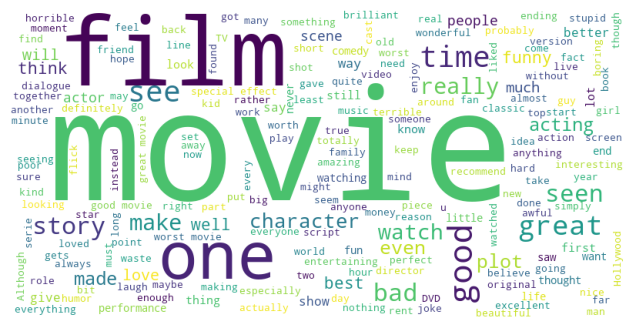

In [40]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400,
                          relative_scaling = 1.0,
                          background_color='white'
                          ).generate(text)
    
    fig = plt.figure(1, figsize=(8, 4))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.savefig("WordCloud.png")

text = " ".join(SA_dataset['Review'].values)
generate_wordcloud(text)

## WORKING WITH SPACY

In [63]:
# Loading the model
model = spacy.load('en_core_web_md')

In [64]:
# Add the pipe
textcat = model.add_pipe('textcat', last=True)

In [66]:
from spacy.training import Example

In [71]:
input = Example.from_dict(model.make_doc('This is a test'), {'cats': {'POSITIVE': 1.0, 'NEGATIVE': 0.0}})


In [73]:
textcat.initialize(lambda: [input], nlp=model)

In [79]:
# Create the optimizer
optimizer = model.resume_training()

In [82]:
# Training the model
from sklearn.model_selection import train_test_split

X = SA_dataset['Review'].values
y = SA_dataset['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
# Training the model
from spacy.training import Example

def create_examples(X, y):
    examples = []
    for text, label in zip(X, y):
        doc = model.make_doc(text)
        examples.append(Example.from_dict(doc, {'cats': {'POSITIVE': int(label), 'NEGATIVE': int(not label)}}))
    return examples

train_examples = create_examples(X_train, y_train)
test_examples = create_examples(X_test, y_test)

In [107]:
# Let's train the model
from spacy.training import Example

n_iter = 2
for i in range(n_iter):
    losses = {}
    model.update(train_examples, losses=losses, drop=0.0, sgd=optimizer)
    print(losses)

{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.14842896163463593}
{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.13713231682777405}


In [96]:
model(test_examples[0].reference).cats

{'POSITIVE': 0.6279250979423523, 'NEGATIVE': 0.3720749318599701}

In [105]:
# Testing the model

def evaluate_model(examples, y_test):
    correct = 0
    total = 0
    results = []
    for example, y in zip(examples, y_test):
        doc = example.reference
        prediction = model(doc)
        if prediction.cats['POSITIVE'] > prediction.cats['NEGATIVE']:
            prediction = 1
        else:
            prediction = 0
        if prediction == y:
            correct += 1
        total += 1
        results.append(prediction)
    return correct / total, results

accuracy, results = evaluate_model(test_examples, y_test)

In [106]:
print("Accuracy: ", accuracy)
from sklearn.metrics import classification_report

print(classification_report(y_test, results))

Accuracy:  0.736
              precision    recall  f1-score   support

           0       0.68      0.82      0.74       464
           1       0.81      0.66      0.73       536

    accuracy                           0.74      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.75      0.74      0.74      1000

